# Customer Churn Prediction with CLV Integration  
### Dataset: Online Retail II

## Business Problem
Which customers are likely to stop purchasing, and how much future revenue is at risk?

This project combines:
- Inactivity-based churn modeling
- Probabilistic CLV estimation (BG/NBD + Gamma-Gamma)
- Business-focused customer segmentation

## Objectives
- Define churn in a retail context
- Predict churn probability per customer
- Estimate future customer value (CLV)
- Identify high-value customers at risk

## Import Required Libraries

In [ ]:
import kagglehub
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.


In [ ]:
!ls /kaggle/input/online-retail-ii-uci

online_retail_II.csv


In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 12.6 MB/s eta 0:00:00


## Library Installation

The `lifetimes` library is required for CLV modeling and is installed manually.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

## Load Online Retail II Dataset

The dataset contains transaction-level retail data including:
- Invoice date
- Customer ID
- Quantity
- Unit price

In [ ]:
df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Initial Data Inspection

We check:
- Shape of dataset
- Missing values
- Data types

In [ ]:
df.shape

(1067371, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


## Data Cleaning

Steps:
1. Remove cancelled invoices
2. Remove negative quantities and prices
3. Drop missing Customer IDs
4. Convert InvoiceDate to datetime

In [ ]:
# Remove cancelled transactions
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove invalid quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Drop missing CustomerID
df = df.dropna(subset=['Customer ID'])

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.shape

(805549, 8)

## Define Reference Date

We use the last transaction date + 1 day
as the reference point for churn definition.


In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

## Churn Definition (Retail Logic)

A customer is considered churned if they have not made
any purchase in the last 120 days.

This inactivity-based definition is common in retail analytics.

In [ ]:
# Last purchase date per customer
last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()

# Days since last purchase
last_purchase['days_since_last_purchase'] = (
    reference_date - last_purchase['InvoiceDate']
).dt.days

# Define churn
last_purchase['churn'] = np.where(
    last_purchase['days_since_last_purchase'] > 120, 1, 0
)

last_purchase.head()

,Customer ID,InvoiceDate,days_since_last_purchase,churn
0,12346.0,2011-01-18 10:01:00,326,1
1,12347.0,2011-12-07 15:52:00,2,0
2,12348.0,2011-09-25 13:13:00,75,0
3,12349.0,2011-11-21 09:51:00,19,0
4,12350.0,2011-02-02 16:01:00,310,1


## Overall Churn Rate

In [ ]:
last_purchase['churn'].value_counts(normalize=True)

,proportion
churn,
0,0.530963
1,0.469037


## Feature Engineering

We build customer-level behavioral features:
- Frequency
- Monetary value
- Average order value
- Customer lifespan

In [ ]:
# Monetary value
df['total_price'] = df['Quantity'] * df['Price']

customer_features = df.groupby('Customer ID').agg(
    frequency=('Invoice', 'nunique'),
    monetary=('total_price', 'sum'),
    avg_order_value=('total_price', 'mean'),
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
).reset_index()

customer_features['customer_lifespan'] = (
    customer_features['last_purchase'] - customer_features['first_purchase']
).dt.days

customer_features.head()

,Customer ID,frequency,monetary,avg_order_value,first_purchase,last_purchase,customer_lifespan
0,12346.0,12,77556.46,2281.072353,2009-12-14 08:34:00,2011-01-18 10:01:00,400
1,12347.0,8,5633.32,22.266087,2010-10-31 14:20:00,2011-12-07 15:52:00,402
2,12348.0,5,2019.40,39.596078,2010-09-27 14:59:00,2011-09-25 13:13:00,362
3,12349.0,4,4428.69,25.306800,2010-04-29 13:20:00,2011-11-21 09:51:00,570
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,0


## Merge Churn Labels with Customer Features

In [ ]:
data = customer_features.merge(
    last_purchase[['Customer ID', 'churn']],
    on='Customer ID',
    how='left'
)

data.head()

,Customer ID,frequency,monetary,avg_order_value,first_purchase,last_purchase,customer_lifespan,churn
0,12346.0,12,77556.46,2281.072353,2009-12-14 08:34:00,2011-01-18 10:01:00,400,1
1,12347.0,8,5633.32,22.266087,2010-10-31 14:20:00,2011-12-07 15:52:00,402,0
2,12348.0,5,2019.40,39.596078,2010-09-27 14:59:00,2011-09-25 13:13:00,362,0
3,12349.0,4,4428.69,25.306800,2010-04-29 13:20:00,2011-11-21 09:51:00,570,0
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,0,1


## Churn Prediction using Logistic Regression

In [ ]:
X = data[['frequency', 'monetary', 'avg_order_value', 'customer_lifespan']]
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       937
           1       0.68      0.74      0.71       827

    accuracy                           0.72      1764
   macro avg       0.72      0.72      0.72      1764
weighted avg       0.72      0.72      0.72      1764

ROC AUC: 0.7960856834245496


## Customer Lifetime Value Estimation

We use probabilistic models to estimate:
- Expected future purchases
- Expected monetary value

In [ ]:
# Create customer-level summary for CLV modeling
summary = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='total_price',
    observation_period_end=reference_date
)

# BG/NBD Model – Purchase Frequency
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

# Gamma-Gamma Model – Monetary Value
# Fit only on valid customers
ggf_data = summary[
    (summary['frequency'] > 0) &
    (summary['monetary_value'] > 0)
]

ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
    ggf_data['frequency'],
    ggf_data['monetary_value']
)

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 11.71, q: 0.88, v: 11.69>

## Calculate 6-Month Customer Lifetime Value

In [ ]:
summary['clv_6_months'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=6,
    freq='M',
    discount_rate=0.01
)

summary[['clv_6_months']].head()

,clv_6_months
Customer ID,
12346.0,387.400669
12347.0,67.552662
12348.0,23.507232
12349.0,35.742285
12350.0,-11.641201


## Churn × CLV Risk Segmentation

In [ ]:
final = data.merge(
    summary[['clv_6_months']],
    left_on='Customer ID',
    right_index=True,
    how='left'
)

final['clv_segment'] = pd.qcut(final['clv_6_months'], q=2, labels=['Low CLV', 'High CLV'])

final['risk_segment'] = final.apply(
    lambda x: 'High Risk'
    if x['churn'] == 1 and x['clv_segment'] == 'High CLV'
    else 'Other',
    axis=1
)

final['risk_segment'].value_counts()

,count
risk_segment,
Other,5319
High Risk,559


## CLV Distribution

This plot shows the distribution of predicted 6-month CLV across customers.

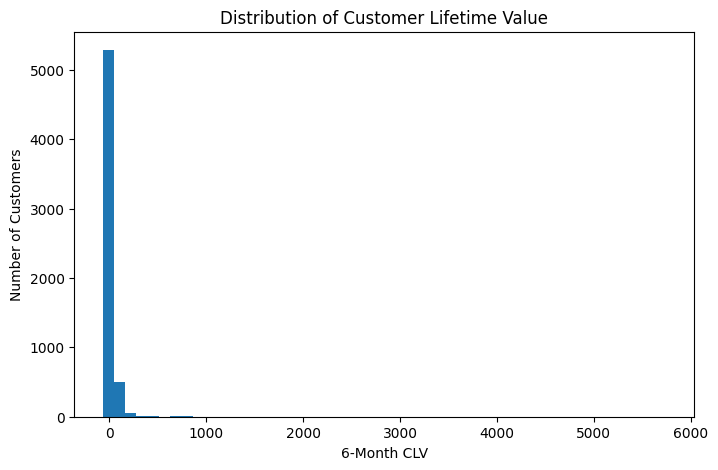

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(final['clv_6_months'], bins=50)
plt.xlabel("6-Month CLV")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Lifetime Value")
plt.show()

## CLV by Risk Segment

<Figure size 700x500 with 0 Axes>

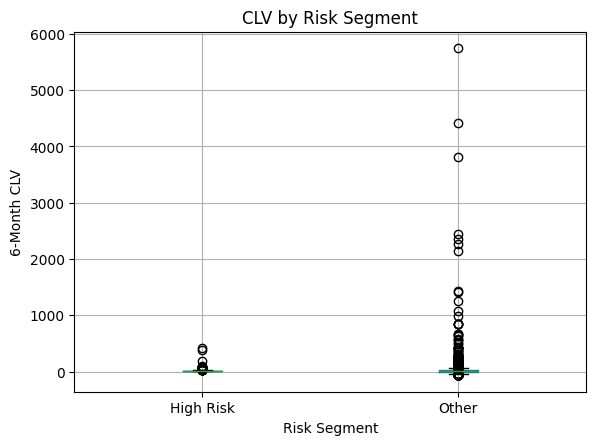

In [ ]:
plt.figure(figsize=(7, 5))
final.boxplot(column='clv_6_months', by='risk_segment')
plt.title("CLV by Risk Segment")
plt.suptitle("")
plt.xlabel("Risk Segment")
plt.ylabel("6-Month CLV")
plt.show()

## Churn vs CLV

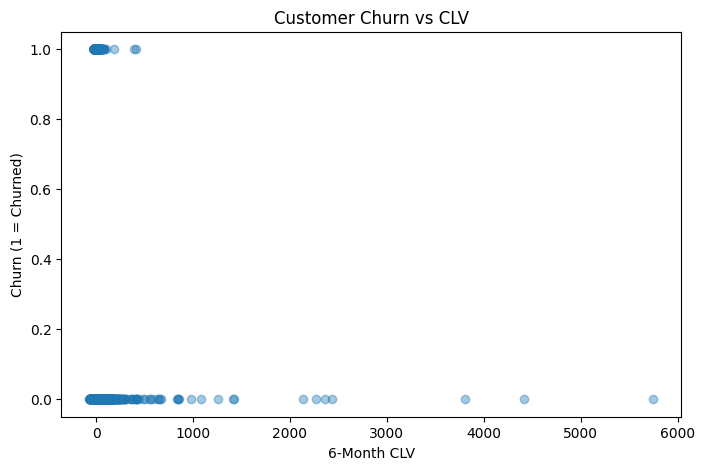

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(
    final['clv_6_months'],
    final['churn'],
    alpha=0.4
)
plt.xlabel("6-Month CLV")
plt.ylabel("Churn (1 = Churned)")
plt.title("Customer Churn vs CLV")
plt.show()

## Customer Count by Risk Segment

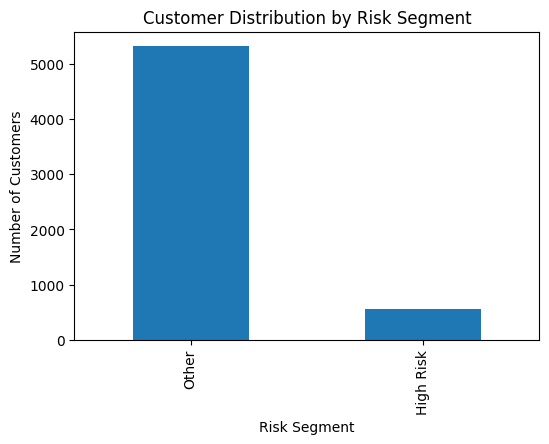

In [ ]:
segment_counts = final['risk_segment'].value_counts()

plt.figure(figsize=(6, 4))
segment_counts.plot(kind='bar')
plt.xlabel("Risk Segment")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by Risk Segment")
plt.show()

## Revenue at Risk from High-Value Churn Customers

In [ ]:
revenue_at_risk = final[final['risk_segment'] == 'High Risk']['clv_6_months'].sum()

revenue_at_risk

np.float64(9484.2133086768)

## Revenue at Risk

The combined 6-month predicted CLV of customers classified as
**High Value and High Churn Risk** is approximately **$9,484**.

This indicates that a small subset of customers represents a
disproportionately high future revenue risk if not retained.

## Key Insights

- Churn prediction using inactivity (last purchase > 120 days) effectively identifies at-risk customers.
- The CLV distribution is highly right-skewed, indicating that a small subset of customers contributes most of the future revenue.
- Purchase frequency and recency are strong behavioral indicators of churn risk.
- Approximately 10% of customers fall into the **High CLV + High Churn Risk** segment.
- Integrating churn with CLV allows prioritization of retention efforts toward the most valuable customers.

## Business Conclusions

- Not all churners are equally important; focusing on high-value customers prevents disproportionate revenue loss.
- Predictive analytics combined with CLV provides actionable insights for targeted retention campaigns.
- Prioritizing high-risk, high-value customers optimizes marketing spend and protects future revenue.
- Probabilistic modeling (BG/NBD + Gamma-Gamma) enables a forward-looking understanding of customer behavior.

## Actionable Recommendations

- Launch personalized retention campaigns for High CLV + High Risk customers.
- Implement real-time monitoring of customer inactivity to detect early churn signals.
- Allocate marketing resources based on predicted CLV and churn risk to maximize ROI.
- Use CLV-risk segmentation to guide loyalty programs, upselling, and cross-selling strategies.

## Conclusion

This project demonstrates how combining **churn prediction** with **Customer Lifetime Value (CLV) modeling** provides actionable insights for retail businesses.

Key takeaways:

1. **Churn Prediction:** Inactivity-based churn modeling identified customers at risk of leaving the business.
2. **CLV Estimation:** Probabilistic models (BG/NBD + Gamma-Gamma) quantified future revenue per customer.
3. **Risk Prioritization:** Approximately 10% of customers were classified as **High Value + High Churn Risk**, representing ₹9,484 in potential 6-month revenue at risk.
4. **Business Implications:** Focusing retention efforts on this small, high-value group optimizes marketing spend and protects future revenue.
5. **Advanced Analytics:** This approach moves beyond descriptive analytics, providing a forward-looking, data-driven strategy for customer retention and growth.

Overall, integrating **behavioral modeling** with **monetary value estimation** allows businesses to identify not just who may churn, but **whose churn matters most**, enabling precise, impactful interventions.